# News Category Dataset
## Identify the type of news based on headlines and short descriptions
https://www.kaggle.com/rmisra/news-category-dataset/kernels?sortBy=dateCreated&group=everyone&pageSize=20&datasetId=32526


In this notebook I'm going to implment a Deep Neural Network using Keras to classify news obtained from HuffPost.

### Load and explore data

In [1]:
import fileinput
import json
import numpy as np
import pandas as pd
from string import punctuation

#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from fasttext import FastText

from keras.callbacks import EarlyStopping #to implment f1
from keras import backend as K #to implement earlystopping
from keras import Model, Input
from keras.layers import Dense

Using TensorFlow backend.


In [20]:
data_df = pd.read_json('../input_data/News_Category_Dataset_v2.json', lines=True)
print('Total number of news: {}'.format(data_df.shape[0]))
data_df.head(3)

Total number of news: 200853


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26


In [22]:
category_count = data_df.groupby("category").size().reset_index()
category_count.columns = ["category", "count"]
print('Number of news per category:')
category_count.sort_values("count", ascending=False)

Number of news per category:


,category,count
24,POLITICS,32739
37,WELLNESS,17827
10,ENTERTAINMENT,16058
34,TRAVEL,9887
30,STYLE & BEAUTY,9649
22,PARENTING,8677
16,HEALTHY LIVING,6694
25,QUEER VOICES,6314
13,FOOD & DRINK,6226
3,BUSINESS,5937


From the list of categories we can notice that some of them are very similar ech other and could be merged, for instance:

- ARTS, ARTS & CULTURE, CULTURE & ARTS
- PARENTING, PARENTS
- STYLE, STYLE & BEAUTY

BTW, for now keep working with original classes.


#### Class distribution

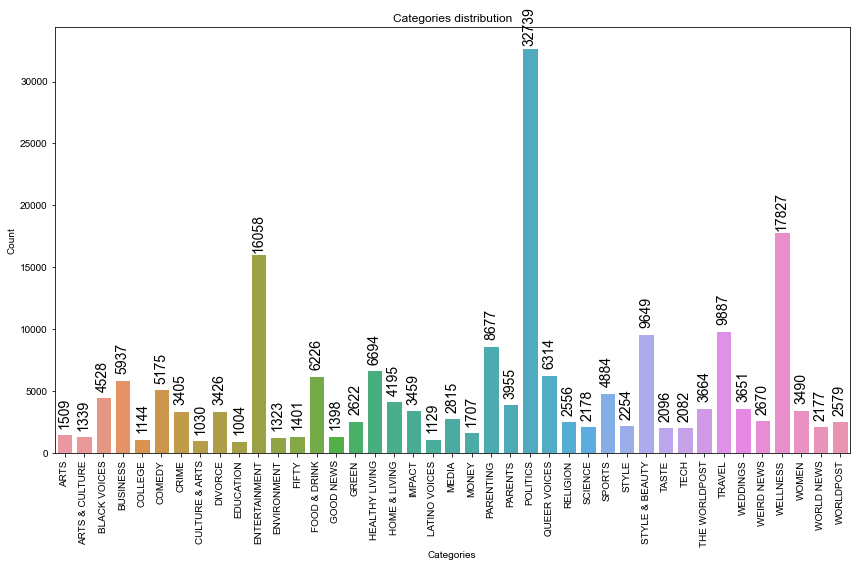

In [4]:


fig = plt.figure(figsize=(12,8))
ax = plt.gca()


sns.set_style("whitegrid")
rcParams['figure.figsize'] = 12,6

g = sns.barplot(data = category_count, x="category", y='count').set(
    xlabel='Categories', 
    ylabel = 'Count'
)


plt.gcf().subplots_adjust(bottom=0.2) # make space for labels
plt.title('Categories distribution', y=1.)
plt.xticks(rotation=90)

for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()+100),
                 ha='center', va='center', fontsize=14, color='black', rotation=90, xytext=(0, 20),
                 textcoords='offset points')  

# In case we ant to save the plot in local        
#plt.savefig(img_path + "")

plt.tight_layout()

## DNN for categories prediction

I will implement a Deep Neural Network where the inputs are the "headline" and the "short description" columns (after a proper preprocessing) and the target value is represented by the "category" column.

The problem we are trying to solve is a multiclass problem, so the output layer of the DNN will have a number of nodes equal to the number of classes and the output of the newtork will be the probability distribution over these classes. This probability distribution is computed through the **softmax** function. The used loss function will be **categorical crossentropy**.

I will transform the input text into embedding vectors using the **FastText** pre-trained word vectors (https://fasttext.cc/docs/en/crawl-vectors.html).

FastText is a word embedding method that is an extension of the word2vec model. Instead of learning vectors for words directly, fastText represents each word as an n-gram of characters. So, for example, take the word, “artificial” with n=3, the fastText representation of this word is <ar, art, rti, tif, ifi, fic, ici, ial, al>, where the angular brackets indicate the beginning and end of the word.   

This helps capture the meaning of shorter words and allows the embeddings to understand suffixes and prefixes. Once the word has been represented using character n-grams, a skip-gram model is trained to learn the embeddings. This model is considered to be a bag of words model with a sliding window over a word because no internal structure of the word is taken into account. As long as the characters are within this window, the order of the n-grams doesn’t matter.  

fastText works well with rare words. So even if a word wasn’t seen during training, it can be broken down into n-grams to get its embeddings.

Word2vec and GloVe both fail to provide any vector representation for words that are not in the model dictionary. This is a huge advantage of this method.  

#### Utilities functions

In [5]:


UNKNOWN_TOKEN = 'UNK'


def clean(s):
    '''Simple utility to make some text cleaning'''
    s = s.strip().replace('\t', ' ')
    s = s.strip().replace('\n', ' ')
    pattern = r"[{}]".format(punctuation) # create the pattern
    return s.translate(str.maketrans('', '', pattern)).lower()

# Read data set
def read_dataset(file_path, parser='json', input_column=None, label_column=None):
    # The label will be a list. In this way this class can be reused also for multilabel problems
    dataset =[]
    data_df = pd.read_json(file_path, lines=True)
    
    for ix, row in data_df.iterrows():
        input = ""
        if isinstance(input_column, list):
            for q in input_column:
                input += row[q] + " "
        else:
            input += row[input_column]
    
        labels = row[label_column]
        if not isinstance(labels, list):
            labels = [labels]
        if input.strip() != "":
            dataset.append(Example(clean(input), labels))
    return dataset


class Example:
    '''Generic dataset example, given an input and a list of labels (I'm using list in case of multilabel problem)'''
    def __init__(self, input, label_list):
        self.input = input
        self.label_list = label_list

class LabelVectorizer:    
    def __init__(self, dataset):
        if isinstance(dataset, list) and isinstance(dataset[0], Example):
            all_labels = (l for e in dataset for l in e.label_list )

        self.labels = [l for l in sorted(set(all_labels)) if l.strip()]
        self.num_labels = len(self.labels)
        self.label_mapping = {l:i for i,l in enumerate(self.labels)}
        self.inverse_mapping = {i:l for l,i in self.label_mapping.items()}

    '''Function to perform label vectorization'''
    def vectorize(self, label_list):
        vector = np.zeros(self.num_labels)
        for label in label_list:
            vector[self.label_mapping[label]] = 1.0
        return vector


#### Custom Metrics

In [6]:

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))


#### DNN Model Implementation

In [7]:

MODEL_TYPES = {
    'multilabel': ('sigmoid', 'binary_crossentropy'),
    'multiclass': ('softmax', 'categorical_crossentropy')
}

def create_model_dnn(embedder, vectorizer, num_hidden, hidden_units, hidden_activation, model_type):
    input_node = Input((embedder.get_dimension(),), name='model_input')
    hidden = input_node
    for i in range(1, num_hidden + 1):
        dense_hidden = Dense(hidden_units, activation=hidden_activation, name='hidden_{}'.format(i))
        hidden = dense_hidden(hidden)
    activation, loss = MODEL_TYPES[model_type]
    output = Dense(vectorizer.num_labels, activation=activation, name='model_output')(hidden)
    model = Model(inputs=input_node, outputs=output)
    model.compile('adam', loss, metrics=['accuracy', f1])
    return model



#### Main Routine

In [8]:
"""Rad dataset, compute word2Vec for the input (Using a FastText pretrained model) and vectorize categories"""

# Read data set
file_path = '../input_data/News_Category_Dataset_v2.json'

# Read data and create a list of objects Example
dataset = read_dataset(file_path, input_column=['short_description','headline'], label_column='category')

# load Fastttext model
fte = FastText.load_model('../../fasttext-embeddings/cc.en.300.bin')
lv = LabelVectorizer(dataset)
print(lv.label_mapping)


np.random.shuffle(dataset) #Shuffling the data is usually appropriate before to create train, valid and test.
# create X and y matrices. For X use Doc2Vec for now
X = np.asarray([fte.get_sentence_vector(example.input) for example in dataset]) #m x 300 matrix, m= # of examples in the dataset
y = np.asarray([lv.vectorize(example.label_list) for example in dataset]) # m x 41 matrix, m= # of examples in the dataset




"""Create training, validation and test set"""
val_samples = 20000
test_samples = 10000

#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train = X[:-(val_samples+test_samples),]
y_train = y[:-(val_samples+test_samples),]
X_valid = X[-(val_samples+test_samples):-val_samples,]
y_valid = y[-(val_samples+test_samples):-val_samples,]
X_test = X[-test_samples:,]
y_test = y[-test_samples:,]

print("\nSize of X_train{}" .format(X_train.shape))
print("Size of y_train{}"   .format(y_train.shape))
print("Size of X_valid{}"   .format(X_valid.shape))
print("Size of y_valid{}"   .format(y_valid.shape))
print("Size of X_test{}"    .format(X_test.shape))
print("Size of y_test{}"    .format(y_test.shape))





"""Implement DNN"""
num_hidden = 4
hidden_units = 600

model = create_model_dnn(fte, lv, num_hidden, hidden_units, 'relu', 'multiclass')
print(model.summary())

# Apply earlystopping
# we will wait 20 epochs before training is stopped. Specifically, this means that we will allow training to continue for up to an additional 20 epochs after the point that validation loss started to degrade
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
model.fit(X,y, validation_data=(X_valid, y_valid), epochs=80, verbose=1, callbacks=[es])



{'ARTS': 0, 'ARTS & CULTURE': 1, 'BLACK VOICES': 2, 'BUSINESS': 3, 'COLLEGE': 4, 'COMEDY': 5, 'CRIME': 6, 'CULTURE & ARTS': 7, 'DIVORCE': 8, 'EDUCATION': 9, 'ENTERTAINMENT': 10, 'ENVIRONMENT': 11, 'FIFTY': 12, 'FOOD & DRINK': 13, 'GOOD NEWS': 14, 'GREEN': 15, 'HEALTHY LIVING': 16, 'HOME & LIVING': 17, 'IMPACT': 18, 'LATINO VOICES': 19, 'MEDIA': 20, 'MONEY': 21, 'PARENTING': 22, 'PARENTS': 23, 'POLITICS': 24, 'QUEER VOICES': 25, 'RELIGION': 26, 'SCIENCE': 27, 'SPORTS': 28, 'STYLE': 29, 'STYLE & BEAUTY': 30, 'TASTE': 31, 'TECH': 32, 'THE WORLDPOST': 33, 'TRAVEL': 34, 'WEDDINGS': 35, 'WEIRD NEWS': 36, 'WELLNESS': 37, 'WOMEN': 38, 'WORLD NEWS': 39, 'WORLDPOST': 40}

Size of X_train(170848, 300)
Size of y_train(170848, 41)
Size of X_valid(10000, 300)
Size of y_valid(10000, 41)
Size of X_test(10000, 300)
Size of y_test(10000, 41)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (In

Epoch 35/80
200848/200848 [==============================] - 56s 280us/step - loss: 0.4360 - accuracy: 0.8561 - f1: 0.8578 - val_loss: 0.3621 - val_accuracy: 0.8773 - val_f1: 0.8773
Epoch 36/80
200848/200848 [==============================] - 57s 283us/step - loss: 0.4194 - accuracy: 0.8606 - f1: 0.8623 - val_loss: 0.3728 - val_accuracy: 0.8772 - val_f1: 0.8775
Epoch 37/80
200848/200848 [==============================] - 57s 282us/step - loss: 0.4206 - accuracy: 0.8604 - f1: 0.8627 - val_loss: 0.3463 - val_accuracy: 0.8818 - val_f1: 0.8828
Epoch 38/80
200848/200848 [==============================] - 57s 282us/step - loss: 0.4101 - accuracy: 0.8651 - f1: 0.8666 - val_loss: 0.3390 - val_accuracy: 0.8859 - val_f1: 0.8888
Epoch 39/80
200848/200848 [==============================] - 57s 283us/step - loss: 0.4075 - accuracy: 0.8671 - f1: 0.8687 - val_loss: 0.3332 - val_accuracy: 0.8841 - val_f1: 0.8846
Epoch 40/80
200848/200848 [==============================] - 56s 281us/step - loss: 0.3996

200848/200848 [==============================] - 56s 280us/step - loss: 0.3164 - accuracy: 0.9066 - f1: 0.9082 - val_loss: 0.2612 - val_accuracy: 0.9189 - val_f1: 0.9195


- We can observe that starting from ~ephoc 70 the model start oscillating but with no significant improvememnt in terms of f1 (as we can also observe in the following plots), so we could stop there.

#### Training and Validation performance

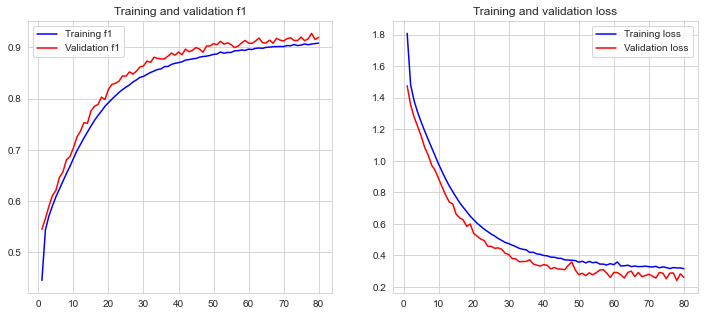

In [9]:

hist = model.history
#print(hist.history.keys())
#print(hist.history['val_f1'])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

train_f1 = hist.history['f1']
valid_f1 = hist.history['val_f1']
epochs = range(1, len(train_f1) + 1)

axes[0].plot(epochs, train_f1, 'b', label=('Training f1') )
axes[0].plot(epochs, valid_f1, 'r', label=('Validation f1' ) )
axes[0].set_title('Training and validation f1')
axes[0].legend()


train_loss = hist.history['loss']
valid_loss = hist.history['val_loss']


axes[1].plot(epochs, train_loss, 'b', label=('Training loss') )
axes[1].plot(epochs, valid_loss, 'r', label=('Validation loss' ) )
axes[1].set_title('Training and validation loss')
axes[1].legend()

### Why is my training loss higher than my testing loss? 
- From keras documentation (https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss)


A Keras model has two modes: training and testing. Regularization mechanisms, such as Dropout and L1/L2 weight regularization, are turned off at testing time. They are reflected in the training time loss but not in the test time loss.

Besides, the training loss is the average of the losses over each batch of training data. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

- May it depend by the distribution of classes in the training, validation and test split?

#### Analyse class distribution in train, valid and test set

In [10]:
train_cats = [lv.inverse_mapping[cat] for cat in y_train.argmax(1)]
valid_cats = [lv.inverse_mapping[cat] for cat in y_valid.argmax(1)]
test_cats = [lv.inverse_mapping[cat] for cat in y_test.argmax(1)]

train_cats = pd.DataFrame(train_cats)
train_cats.columns = ["class"]
train_cats = train_cats.groupby("class").size().reset_index()
train_cats.columns = ["class", "count_train"]
train_cats["freq_train"] = train_cats["count_train"]/train_cats["count_train"].sum()*100
train_cats

valid_cats = pd.DataFrame(valid_cats)
valid_cats.columns = ["class"]
valid_cats = valid_cats.groupby("class").size().reset_index()
valid_cats.columns = ["class", "count_valid"]
valid_cats["freq_valid"] = valid_cats["count_valid"]/valid_cats["count_valid"].sum()*100
valid_cats


test_cats = pd.DataFrame(test_cats)
test_cats.columns = ["class"]
test_cats = test_cats.groupby("class").size().reset_index()
test_cats.columns = ["class", "count_test"]
test_cats["freq_test"] = test_cats["count_test"]/test_cats["count_test"].sum()*100
test_cats

class_dist_temp = pd.merge(train_cats, valid_cats, on="class")
class_dist = pd.merge(class_dist_temp, test_cats, on="class")

class_dist.head()

,class,count_train,freq_train,count_valid,freq_valid,count_test,freq_test
0,ARTS,1297,0.759154,84,0.84,63,0.63
1,ARTS & CULTURE,1145,0.670186,61,0.61,64,0.64
2,BLACK VOICES,3834,2.244100,204,2.04,242,2.42
3,BUSINESS,5005,2.929505,308,3.08,313,3.13
4,COLLEGE,978,0.572439,60,0.60,54,0.54


In [11]:
# Prepare dataset to plot
class_dist = class_dist[["class", "freq_train", "freq_valid", "freq_test"]].melt(id_vars=['class'], var_name='split')
class_dist

,class,split,value
0,ARTS,freq_train,0.759154
1,ARTS & CULTURE,freq_train,0.670186
2,BLACK VOICES,freq_train,2.244100
3,BUSINESS,freq_train,2.929505
4,COLLEGE,freq_train,0.572439
...,...,...,...
118,WEIRD NEWS,freq_test,1.420000
119,WELLNESS,freq_test,8.670000
120,WOMEN,freq_test,1.910000
121,WORLD NEWS,freq_test,1.230000


In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

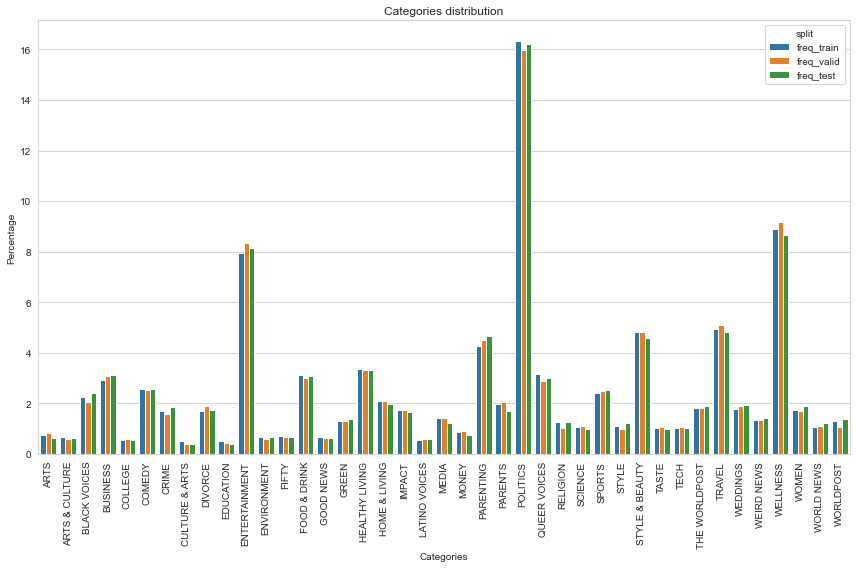

In [13]:


fig = plt.figure(figsize=(12,8))
ax = plt.gca()


sns.set_style("whitegrid")
#rcParams['figure.figsize'] = 12,6

g = sns.barplot(data = class_dist, x="class", y='value', hue="split").set(
    xlabel='Categories', 
    ylabel = 'Percentage'
)


#plt.gcf().subplots_adjust(bottom=0.2) # make space for labels
plt.title('Categories distribution', y=1.)
plt.xticks(rotation=90)
# In case we ant to save the plot in local        
#plt.savefig(img_path + "")

plt.tight_layout()

- The categories are correctly distributed in training, validation and test set.

#### Evaluation on test set

In [14]:
"""Model Evaluation"""

# Compute predictions on validation set and analyse classificaition report
yp_test_temp = model.predict(X_test)

#set the class with maximum value to 1 and the remaining to 0
yp_test = np.zeros(yp_test_temp.shape)
yp_test[np.arange(len(yp_test_temp)), yp_test_temp.argmax(1)] = 1


metrics = precision_recall_fscore_support(y_test, yp_test, average='micro')
print('Model performance on the test split: \n Precision: {} \n Recall: {} \n F1-Score: {} \n Support: {} \n\n'.format(*metrics))


report = classification_report(y_test, yp_test,  output_dict=True)
formatted_report = {}
for k,v in report.items():
    try:
        formatted_report[lv.inverse_mapping[int(k)]] = v
    except:
        formatted_report[k] = v
df_report = pd.DataFrame(formatted_report).transpose()

print("Classification report on Test set\n")
print(df_report)




Model performance on the test split: 
 Precision: 0.9209 
 Recall: 0.9209 
 F1-Score: 0.9209 
 Support: None 


Classification report on Test set

                precision    recall  f1-score  support
ARTS             0.875000  0.888889  0.881890     63.0
ARTS & CULTURE   0.867647  0.921875  0.893939     64.0
BLACK VOICES     0.932773  0.917355  0.925000    242.0
BUSINESS         0.890244  0.932907  0.911076    313.0
COLLEGE          0.960000  0.888889  0.923077     54.0
COMEDY           0.902256  0.937500  0.919540    256.0
CRIME            0.988235  0.898396  0.941176    187.0
CULTURE & ARTS   0.767442  0.868421  0.814815     38.0
DIVORCE          0.901099  0.931818  0.916201    176.0
EDUCATION        0.941176  0.800000  0.864865     40.0
ENTERTAINMENT    0.958647  0.939803  0.949132    814.0
ENVIRONMENT      0.923077  0.895522  0.909091     67.0
FIFTY            0.875000  0.811594  0.842105     69.0
FOOD & DRINK     0.947883  0.941748  0.944805    309.0
GOOD NEWS        0.864407  0

Text(0.5, 1.0, 'Test Set Confusion Matrix')

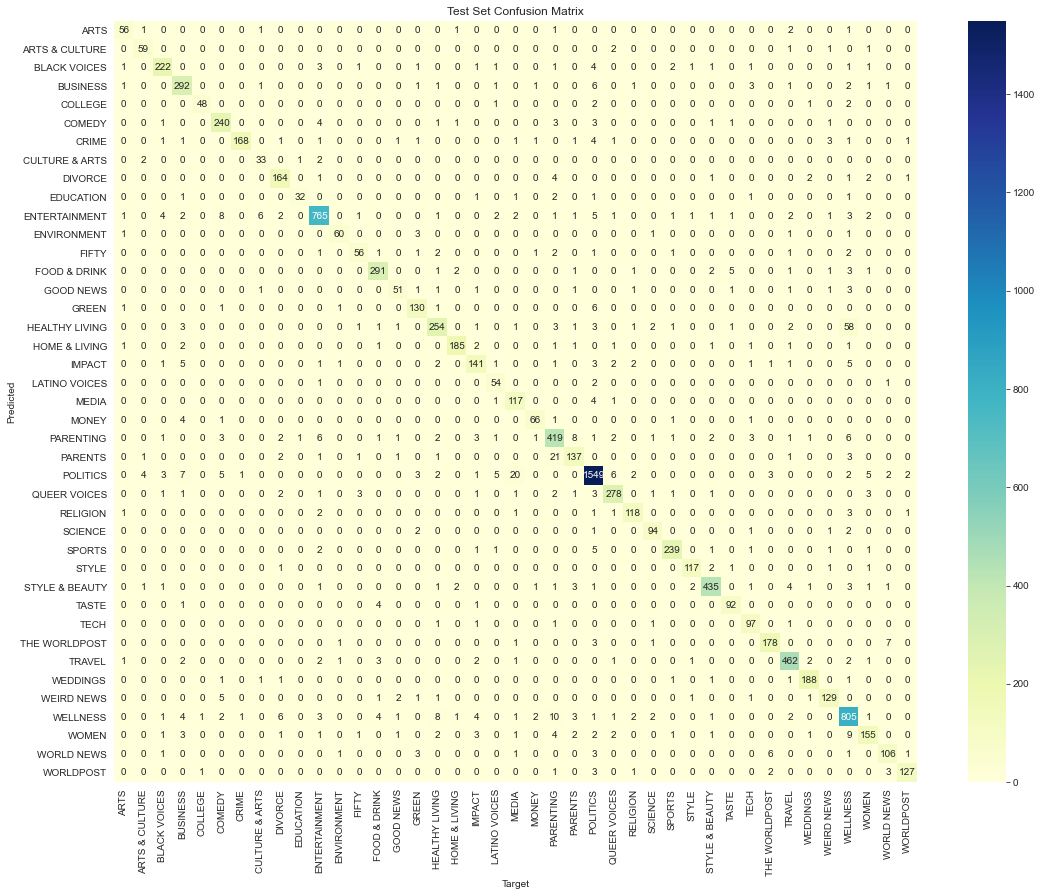

In [15]:

unique_label = lv.label_mapping.keys()
cmtx = pd.DataFrame(
    confusion_matrix(y_test.argmax(axis=1), yp_test.argmax(axis=1)), 
    index=['{:}'.format(x) for x in unique_label], 
    columns=['{:}'.format(x) for x in unique_label]
)

plt.figure(figsize=(18, 14))
ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
ax.set_ylabel('Predicted')
ax.set_xlabel('Target');
ax.set_title("Test Set Confusion Matrix", size=12)

- From the confusion matrix we can observe that one class where the model faces some difficult is ```WELLNESS``` (e.g., many examples of this class are classified as ```HEALTHY LIVING```).

#### Prediciotns

In [16]:
def make_prediction(model, news):  
    """Predict the category of a news."""
    test_example_arr = np.array(fte.get_sentence_vector(news)).reshape(1,-1)
    pred = model.predict(test_example_arr)[0]
    return lv.inverse_mapping[pred.argmax()]


In [17]:
test_example = "Democrats Slam Trump's 'Politically Motivated' Ousting Of Transportation Watchdog"
make_prediction(model, test_example)

'POLITICS'

In [18]:
test_example = "the futbol match was very interesting."
make_prediction(model, test_example)

'SPORTS'

In [19]:
test_example = "Thousands Evacuated In Michigan After Heavy Rain Causes Dams To Breach. Rapidly rising water overtook dams and forced the evacuation of about 10,000 people in central Michigan, where the governor said one downtown could be under approximately 9 feet of water by Wednesday."
make_prediction(model, test_example)

'GREEN'